To note:

- No idea what b is 
- Below is a couple of definitions from the GitHub page which might come in handy

Link travel time = free flow time * ( 1 + B * (flow/capacity)^Power ).
Link generalized cost = Link travel time + toll_factor * toll + distance_factor * distance

# Setup: import packages

In [1]:
#install packages if required
#%pip install networkx

In [2]:
#import packages 
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
from scipy.misc import derivative
import os
from random import *

In [3]:
network_analysis_path_ben = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/pytrans_UrbanNetworkAnalysis/pytrans/UrbanNetworkAnalysis/testing'
#network_analysis_path_niamh = r'C:\Users\35387\OneDrive\Documents\Networks\New folder\Networks_Term_Paper\pytrans_UrbanNetworkAnalysis\pytrans\UrbanNetworkAnalysis\original_edited'
os.chdir(network_analysis_path_ben)
import Frank_Wolfe
import TransportationNetworks as tn
import visualize_graph

In [4]:
#create cities dictionary
def make_dict(cities):
    cities_dict = {}
    for city in cities:
        link_file_path = data_path + city + '/' + city + '_net.tntp.txt'
        node_file_path = data_path + city + '/' + city +'_nodes.tntp.txt'
        trip_file_path = data_path + city + '/' + city + '_trips.tntp.txt'
        cities_dict[city] = {}
        to_add = {'link_file_path': link_file_path, 'node_file_path': node_file_path, 'trip_file_path': trip_file_path}
        cities_dict[city]['file_paths'] = to_add 
    return cities_dict

In [5]:
#create class
class fw_custom_algorithm():
    
    def __init__(self, cities_dict):
        self.cities_dict = cities_dict
        self.link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, "B": 6, "beta": 7, "V": 8}
    #create a csv for each city and corresponding file for investigation
 
    #need to fix this to make 
    def create_links_csv(self):
        for city in self.cities_dict.keys():
            path_list = list(self.cities_dict[city]['file_paths'])
            link_file = path_list[0]
            csv = pd.read_csv(self.cities_dict[city]['file_paths'][link_file], skiprows=7, sep='\t') #gets link file path
            trimmed= [s.strip().lower() for s in csv.columns]
            csv.columns = trimmed
            # And drop the silly first andlast columns
            csv.drop(['~', ';'], axis=1, inplace=True)
            cities_dict[city]['csv'] = csv
        self.cities_dict = cities_dict
    
    def plot(self, city):
        csv = self.cities_dict[city]['csv']
        network = nx.from_pandas_edgelist(csv, source = 'init node',target='term node', edge_attr = True)
        graph = nx.complete_graph(network)
        print('Graph for:', city)
        nx.draw(graph)
        
    def summary_stats_all(self):
        for city in self.cities_dict.keys():
            print('Total number of nodes in', city+':', len(self.cities_dict[city]['csv']['init node'].unique()))
            print('Total number of edges in', city+':', self.cities_dict[city]['csv'].shape[0])
            
    def make_network(self, city, remove_link_number): #remove_link_number can be None or int
        #instatiate class using required files 
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path']
        Network = tn.Network(remove_link_number, link_file, trip_file, node_file) 
        self.cities_dict[city][str(remove_link_number)] = {'network': Network}
            
    def network_attributes(self, city, remove_link_number):
        network = self.cities_dict[city][str(remove_link_number)]['network']
        ##Network has three attributes
        #1) graph object
        graph = network.graph
        #2) origin nodes
        origin_nodes = network.origins
        #3)dict: keys= origin_node, destination_node, value = traffic flow
        flows = network.od_vols
        print(network)
        print(city, 'graph is:', graph)
        print(city, 'origin nodes are:', origin_nodes)
        print(city, 'flows are:', flows)
    
    def compute_link_flow(self, city, remove_link_number):
        network = self.cities_dict[city][str(remove_link_number)]['network']
        SO = False
        fw = Frank_Wolfe.Run(network, SO)
        #saves file to dict
        self.cities_dict[city][str(remove_link_number)]['fw_run'] = fw
        



In [6]:
"""
    def network_attributes_all_links(self, city):
        network =  self.cities_dict[city]['no_links_removed']['network']
        ##Network has three attributes
        #1) graph object
        graph = network.graph
        #2) origin nodes
        origin_nodes = network.origins
        #3)dict: keys= origin_node, destination_node, value = traffic flow
        flows = network.od_vols
        print(network)
        print(city, 'graph is:', graph)
        print(city, 'origin nodes are:', origin_nodes)
        print(city, 'flows are:', flows)
        
    def network_attributes_link_removed(self, city, link_removed):
        network = self.cities_dict[city]['links_removed'][str(link_removed)]['network']
        ##Network has three attributes
        #1) graph object
        graph = network.graph
        #2) origin nodes
        origin_nodes = network.origins
        #3)dict: keys= origin_node, destination_node, value = traffic flow
        flows = network.od_vols
        print(network)
        print(city, 'graph is:', graph)
        print(city, 'origin nodes are:', origin_nodes)
        print(city, 'flows are:', flows)
"""
        

    
""""     
    #define a function for finding the equilibrim flow using the Frank-Wolfe algorithm from PyTrans
    def compute_all_link_flow(self, city):
        network = self.cities_dict[city]['no_links_removed']['network']
        SO = False
        fw = Frank_Wolfe.Run(network, SO)
        #saves file to dict
        self.cities_dict[city]['no_links_removed'] = {'fw_run': fw}
    
    def compute_removed_link_flow(self, city, link_removed):
        network = self.cities_dict[city]['links_removed'][str(link_removed)]['network']
        SO = False
        fw = Frank_Wolfe.Run(network, SO)
        #saves file to dict
        self.cities_dict[city]['links_removed'][str(link_removed)] = {'fw_run': fw}
"""
        

    
    #def compute_missing_link_flow(self, city):   
        
    #def remove_link(self, city, link_file, link):
    #    f = open(link_file)
     #   lines = f.readlines()
      #  f.close()
        

                
        #if remove_link_number == 0:
         #   Network = tn.Network(remove_link_number, link_file, trip_file, node_file) 
          #  self.cities_dict[city]['no_links_removed'] = {'network': Network}
        #elif type(remove_link_number) == int:
         #   Network = tn.Network(remove_link_number, link_file, trip_file, node_file) 
          #  self.cities_dict[city]['links_removed'] = {}
           # self.cities_dict[city]['links_removed'][str(remove_link_number)] = {'network': Network}
    

'"     \n    #define a function for finding the equilibrim flow using the Frank-Wolfe algorithm from PyTrans\n    def compute_all_link_flow(self, city):\n        network = self.cities_dict[city][\'no_links_removed\'][\'network\']\n        SO = False\n        fw = Frank_Wolfe.Run(network, SO)\n        #saves file to dict\n        self.cities_dict[city][\'no_links_removed\'] = {\'fw_run\': fw}\n    \n    def compute_removed_link_flow(self, city, link_removed):\n        network = self.cities_dict[city][\'links_removed\'][str(link_removed)][\'network\']\n        SO = False\n        fw = Frank_Wolfe.Run(network, SO)\n        #saves file to dict\n        self.cities_dict[city][\'links_removed\'][str(link_removed)] = {\'fw_run\': fw}\n'

# Set file paths

In [7]:
data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/'
cities = ['testing']
data_path = data_path 
os.chdir(data_path)

# Make dict

In [8]:
cities_dict = make_dict(cities)
cities_dict

{'testing': {'file_paths': {'link_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/testing/testing_net.tntp.txt',
   'node_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/testing/testing_nodes.tntp.txt',
   'trip_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/testing/testing_trips.tntp.txt'}}}

# instantiate class

In [9]:
#instantiate class 
trial_run = fw_custom_algorithm(cities_dict)

# Observe one city

In [10]:
#set city for investigation
city = cities[0]

In [11]:
trial_run.create_links_csv()
cities_dict[city]['csv']

,init node,term node,capacity,length,free flow time,b,power,speed limit,toll,type
0,1,2,25900.200640,6,6,0.15,4,0,0,1
1,1,3,23403.473190,4,4,0.15,4,0,0,1
2,2,1,25900.200640,6,6,0.15,4,0,0,1
3,2,6,4958.180928,5,5,0.15,4,0,0,1
4,3,1,23403.473190,4,4,0.15,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...
71,23,22,5000.000000,4,4,0.15,4,0,0,1
72,23,24,5078.508436,2,2,0.15,4,0,0,1
73,24,13,5091.256152,4,4,0.15,4,0,0,1
74,24,21,4885.357564,3,3,0.15,4,0,0,1


# Plot graph

Total number of nodes in testing: 24
Total number of edges in testing: 76
Graph for: testing


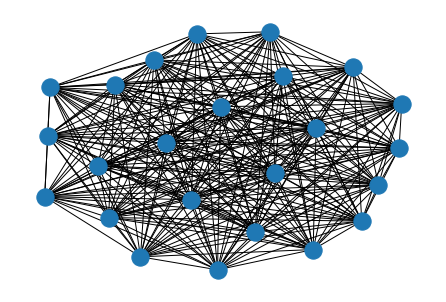

In [12]:
#Create csvs, plot graph and show summary stats
trial_run.summary_stats_all()
trial_run.plot(city)

#load node file
        brum_nodes = pd.read_csv(node_file_path, sep = ' ')
for_drop = []
for i in list(range(1,14)):
    name = 'Unnamed: ' + str(i)
    for_drop.append(name)
for_drop.remove('Unnamed: 7')
brum_nodes = brum_nodes.drop(for_drop, axis = 1)

#load trips file
#load node file - note this is a bit fiddly, could be a better way to import but chose something quick and dirty
brum_nodes = pd.read_csv(node_file_path, sep = ' ')
for_drop = []
for i in list(range(1,14)):
    name = 'Unnamed: ' + str(i)
    for_drop.append(name)
for_drop.remove('Unnamed: 7')
brum_nodes = brum_nodes.drop(for_drop, axis = 1)

# Observe example network data

In [13]:
#observe network with all links
remove_link = 0 #0 is equivalent to no links closed
trial_run.make_network(city, remove_link)
trial_run.network_attributes(city, remove_link)

testing graph is: DiGraph with 24 nodes and 76 edges
testing origin nodes are: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
testing flows are: {('1', '1'): 0.0, ('1', '2'): 100.0, ('1', '3'): 100.0, ('1', '4'): 500.0, ('1', '5'): 200.0, ('1', '6'): 300.0, ('1', '7'): 500.0, ('1', '8'): 800.0, ('1', '9'): 500.0, ('1', '10'): 1300.0, ('1', '11'): 500.0, ('1', '12'): 200.0, ('1', '13'): 500.0, ('1', '14'): 300.0, ('1', '15'): 500.0, ('1', '16'): 500.0, ('1', '17'): 400.0, ('1', '18'): 100.0, ('1', '19'): 300.0, ('1', '20'): 300.0, ('1', '21'): 100.0, ('1', '22'): 400.0, ('1', '23'): 300.0, ('1', '24'): 100.0, ('2', '1'): 100.0, ('2', '2'): 0.0, ('2', '3'): 100.0, ('2', '4'): 200.0, ('2', '5'): 100.0, ('2', '6'): 400.0, ('2', '7'): 200.0, ('2', '8'): 400.0, ('2', '9'): 200.0, ('2', '10'): 600.0, ('2', '11'): 200.0, ('2', '12'): 100.0, ('2', '13'): 300.0, ('2', '14'): 100.0, ('2', '15'): 100.0, ('2', 

In [14]:
#observe network after removing one link
remove_link = 1
trial_run.make_network(city, remove_link)
trial_run.network_attributes(city, remove_link)

testing graph is: DiGraph with 24 nodes and 75 edges
testing origin nodes are: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
testing flows are: {('1', '1'): 0.0, ('1', '2'): 100.0, ('1', '3'): 100.0, ('1', '4'): 500.0, ('1', '5'): 200.0, ('1', '6'): 300.0, ('1', '7'): 500.0, ('1', '8'): 800.0, ('1', '9'): 500.0, ('1', '10'): 1300.0, ('1', '11'): 500.0, ('1', '12'): 200.0, ('1', '13'): 500.0, ('1', '14'): 300.0, ('1', '15'): 500.0, ('1', '16'): 500.0, ('1', '17'): 400.0, ('1', '18'): 100.0, ('1', '19'): 300.0, ('1', '20'): 300.0, ('1', '21'): 100.0, ('1', '22'): 400.0, ('1', '23'): 300.0, ('1', '24'): 100.0, ('2', '1'): 100.0, ('2', '2'): 0.0, ('2', '3'): 100.0, ('2', '4'): 200.0, ('2', '5'): 100.0, ('2', '6'): 400.0, ('2', '7'): 200.0, ('2', '8'): 400.0, ('2', '9'): 200.0, ('2', '10'): 600.0, ('2', '11'): 200.0, ('2', '12'): 100.0, ('2', '13'): 300.0, ('2', '14'): 100.0, ('2', '15'): 100.0, ('2', 

# Compute equilibrium flow for example city using Frank-Wolfe algorithm

In [15]:
#compute the eq flow for one example city and no closed links
remove_link = 0
trial_run.compute_link_flow(city, remove_link)

Results for: testing
1  ->  2 :  4494.541769891608
1  ->  3 :  8118.778958018833
2  ->  1 :  4519.221797661597
2  ->  6 :  5967.415424264172
3  ->  1 :  8094.098930248844
3  ->  4 :  14011.734532365375
3  ->  12 :  10027.635980625804
6  ->  2 :  5992.095452034151
6  ->  5 :  8806.410890570694
6  ->  8 :  12492.075338963252
4  ->  3 :  14035.300255284554
4  ->  5 :  18010.561177668467
4  ->  11 :  5203.13865525387
12  ->  3 :  9979.390229936655
12  ->  11 :  8404.306735865635
12  ->  13 :  12293.499582309718
5  ->  4 :  18034.525518068713
5  ->  6 :  8797.1895868881
5  ->  9 :  15783.996289327333
11  ->  4 :  5302.740037772761
11  ->  10 :  17603.652145860353
11  ->  12 :  8365.259304287434
11  ->  14 :  9776.846543284393
9  ->  5 :  15798.73932604504
9  ->  8 :  6837.003588255241
9  ->  10 :  21745.98823492458
8  ->  6 :  12525.976670415792
8  ->  7 :  12041.696631484156
8  ->  9 :  6881.813917130209
8  ->  16 :  8387.782258682433
7  ->  8 :  12102.268632570476
7  ->  18 :  15797.41185

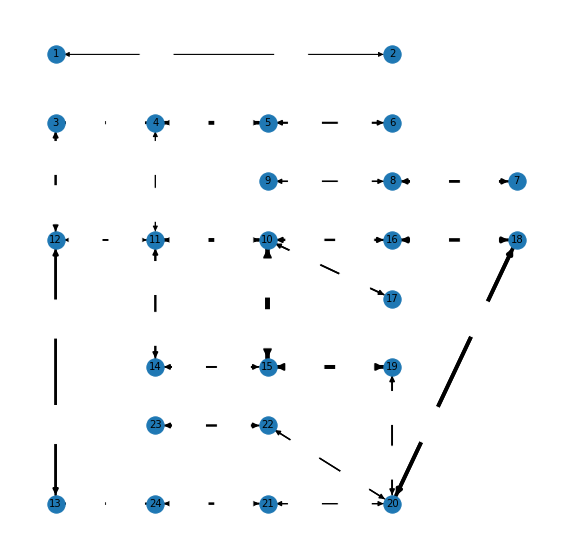

In [16]:
#this is the output of the 
print('Results for:', city)
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlow() #equilibrium flows
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlowMap() #flow map

# Compute equilibrium flow for one closed link in example city using Frank-Wolfe algorithm

In [17]:
#compute the eq flow for one example city and one closed link
remove_link = 1
trial_run.compute_link_flow(city, remove_link)

Results for: testing
1  ->  2 :  4965.7880830145
1  ->  3 :  8369.381896331546
2  ->  1 :  4770.035942663004
2  ->  6 :  6301.521997851713
3  ->  1 :  8565.134036683055
3  ->  4 :  16459.458086119863
3  ->  12 :  10607.948612168271
6  ->  2 :  6105.769857500197
6  ->  5 :  8800.910473431877
6  ->  8 :  12971.172531606147
4  ->  3 :  14902.088290039928
4  ->  5 :  19580.047546394428
4  ->  11 :  6081.015453411736
12  ->  3 :  12361.07054859975
12  ->  11 :  9109.643572460269
12  ->  13 :  12575.663951386037
5  ->  4 :  18898.776596238593
5  ->  6 :  8804.536002488156
5  ->  9 :  17010.577749550812
11  ->  4 :  5304.916607487626
11  ->  10 :  17393.9656458668
11  ->  12 :  8766.163133941585
11  ->  14 :  10371.136497529289
9  ->  5 :  16332.932328451325
9  ->  8 :  6984.55009184866
9  ->  10 :  22826.03448628367
8  ->  6 :  12771.79486219838
8  ->  7 :  12499.75987181408
8  ->  9 :  7001.093896310519
8  ->  16 :  8556.407579656438
7  ->  8 :  12365.974727487714
7  ->  18 :  16397.2109864

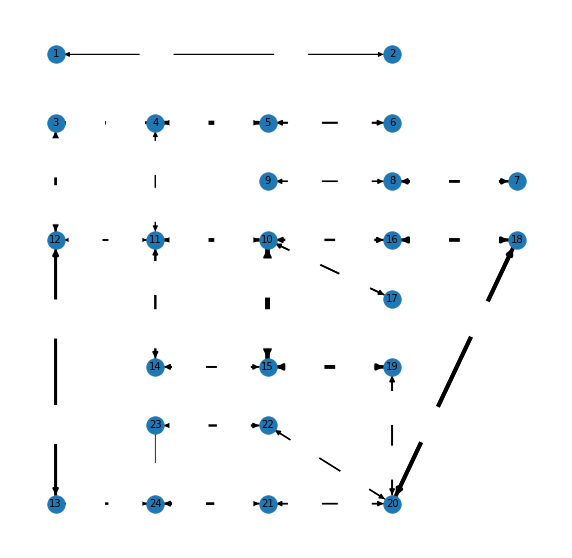

In [18]:
#this is the output of the 
print('Results for:', city)
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlow() #equilibrium flows
trial_run.cities_dict[city][str(remove_link)]['fw_run'].showODFlowMap() #flow map

# Systematically close each link and compute equilibrium flow for example city

In [ ]:
for city in cities:
    